# Sentinel-1 Cumulative Sum Analysis to Map Forest Disturbances

#### Code by Chiara Aquino
#### Modified by Rajat Dhane



In [ ]:
# #import earth engine API
import ee

# # Authenticate and Initialise
ee.Authenticate()
ee.Initialize()

Install Libraries

In [ ]:
# install the libraries if required
!pip install geemap
!pip install os
!pip install xarray
!pip install rioxarray
!pip install pyshp
!pip install pycrs
!pip install glob2

Import Libraries

In [ ]:
import geemap
import os
import xarray as xr
import rioxarray
import numpy as np
import glob2 as glob
import datetime
import pandas as pd

#### Image Processing Functions

In [ ]:
#convert from sigma_0 to gamma_0
def toGamma0(image):
  gamma0 = image.select('VH').subtract(image.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0));
  return gamma0.copyProperties(image).copyProperties(image,['system:time_start']);

# mosaic images with the same date that have been spatially split
def mosaicByDate(imcol):
    imlist = imcol.toList(imcol.size())
    unique_dates = imlist.map(lambda im: ee.Image(im).date().format("YYYY-MM-dd")).distinct()
    def mosaic_imlist(d):
        d = ee.Date(d)
        im = imcol.filterDate(d, d.advance(1, "day")).mosaic()
        return im.set(
        "system:time_start", d.millis(),
        "system:id", d.format("YYYY-MM-dd"));

    return ee.ImageCollection(unique_dates.map(mosaic_imlist))

#### Define input parameters

In [ ]:
# define year of the analysis
year = 2022;
START_DATE = str(year-1)+"-01-01"; #no image before
END_DATE = str(year+1)+"-07-01"; #exclusive = ie., until 2021-06-31

# define image projection
crs = "EPSG:4326"

Mount Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# force remount if necessary
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# define your area of interest
# aoi_shp = "/content/drive/My Drive/FODEX/AOI/AOI_FODEX.shp"
aoi_shp = "/content/drive/My Drive/AOI/AOI_Extent.shp"
aoi = geemap.shp_to_ee(aoi_shp)

# choose a path for your output directory. This is where you will have saved all the images in the collection
outdir = "/content/drive/My Drive/Cusum_data/DSC_VH/"

#### Download Image Collection


In [ ]:
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(aoi).filterDate(ee.Date(START_DATE), ee.Date(END_DATE))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
          .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH'])
          .filterMetadata('resolution_meters', 'equals', 10)
          .map(toGamma0)
          .map(lambda image:image.clip(aoi.geometry())))

# select Vh polarization
vh = collection.select(['VH'])
vh_size = vh.size().getInfo()
print('original size of Image Stack: ', vh_size)

# get image dates
imlist = vh.toList(vh.size())
unique_dates = imlist.map(lambda im:ee.Image(im).date().format("YYYY-MM-dd")).distinct()
date_list = unique_dates.getInfo()

# mosaic images with same date
vh_mosaic = mosaicByDate(vh)
mosaic_size = vh_mosaic.size().getInfo()
print('size of Image Stack after mosaicking: ' ,mosaic_size)

# export Image Collection to your folder (Uncomment while running)
# geemap.ee_export_image_collection(vh_mosaic, scale=10,out_dir=outdir, region=aoi.geometry(),crs=crs)

original size of Image Stack:  75
size of Image Stack after mosaicking:  75


#### Convert Image Collection to xarray

In [ ]:
# list all downloaded images of Vh
vh_tifs = os.listdir(outdir)
files_vh = list(filter(os.path.isfile, glob.glob(outdir + "*.tif")))

#sort images by download time for Vh
files_vh.sort(key=lambda x: os.path.getctime(x))

# loop through the list, open image as xarray and assign time label
list_da_vh=[]
for file, date in zip(files_vh, date_list):
    da = rioxarray.open_rasterio(file,masked=True)
    dt = datetime.datetime.strptime(date,"%Y-%m-%d")
    dt = pd.to_datetime(dt)
    da = da.assign_coords(time = dt)
    da = da.expand_dims(dim="time")
    list_da_vh.append(da)

#stack data arrays in list
ds = xr.combine_by_coords(list_da_vh)

#### CumSum implementation

In [ ]:
# get timeseries mean
dsmean = ds.mean(dim='time')
#get time series residual
R = ds-dsmean
# get time series cumulative sum
S = R.cumsum(dim="time")
# get maximum of the cumulative sum
Smax= S.max(dim="time")
# the threshold is calculated as 99th percentile of the CuSum max
threshold = np.percentile(Smax, 88)
# filter cumulative sum array by year of interest
Sfilt_time = S[S['time.year']==year]
# convert to DOY
Sfilt_time['time'] = Sfilt_time["time.dayofyear"]
# spatially filter by 99th percentile
Sfilt_n = Sfilt_time.where(Sfilt_time>= threshold,np.nan)
# determine where you have valid data
mask = Sfilt_n['time'].isel(time=0).notnull()
#convert Nan to calculate maximum
Sfilt_n2 = Sfilt_n.fillna(-9999)
# get the date where the curve reaches the maximum value
Sfilt_max = Sfilt_n2.isel(time = Sfilt_n2.argmax('time')).where(mask)

max_values = Sfilt_max.where(Sfilt_max> -9999,np.nan)
max_dates = Sfilt_n.idxmax(dim="time")

max_values.name = 'Smax'
max_dates.name = 'doy'

#### Save outputs


In [ ]:
intensityName = '/content/drive/My Drive/Cusum_output/Smax_VH_88.tif'   # path to your folder for Smax intensity image
dateName = '/content/drive/My Drive/Cusum_output/Dates_VH_88.tif'       # path to your folder for Date image

max_values_raster = max_values.rio.write_crs(crs)
max_values_raster.rio.to_raster(intensityName)

max_dates_raster = max_dates.rio.write_crs(crs)
max_dates_raster.rio.to_raster(dateName)

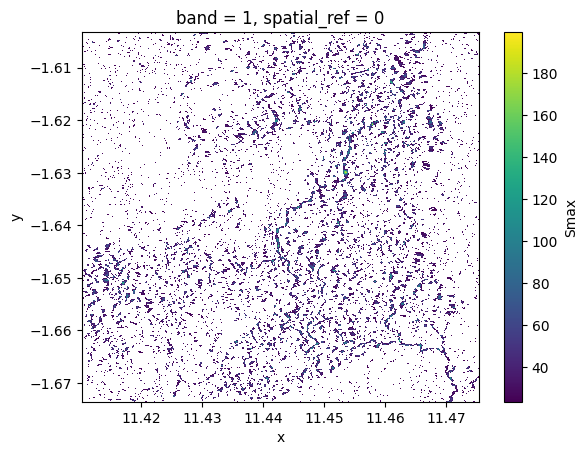

In [ ]:
max_values.plot()

STANDARDIZED OUTPUT

In [ ]:
# Calculate mean and
dsmean = ds.mean(dim='time')

# standard deviation of the entire time series
std = ds.std(dim='time')

# Standardize data with z-score normalization
ds_std = (ds - dsmean) / std

# get time series cumulative sum
S = ds_std.cumsum(dim="time")

# get maximum of the cumulative sum
Smax= S.max(dim="time")

# the threshold is calculated as 99th percentile of the CuSum max
threshold = np.percentile(Smax, 88)
# filter cumulative sum array by year of interest
Sfilt_time = S[S['time.year']==year]
# convert to DOY
Sfilt_time['time'] = Sfilt_time["time.dayofyear"]
# spatially filter by 99th percentile
Sfilt_n = Sfilt_time.where(Sfilt_time>= threshold,np.nan)
# determine where you have valid data
mask = Sfilt_n['time'].isel(time=0).notnull()
#convert Nan to calculate maximum
Sfilt_n2 = Sfilt_n.fillna(-9999)
# get the date where the curve reaches the maximum value
Sfilt_max = Sfilt_n2.isel(time = Sfilt_n2.argmax('time')).where(mask)

max_values = Sfilt_max.where(Sfilt_max> -9999,np.nan)
max_dates = Sfilt_n.idxmax(dim="time")

max_values.name = 'Smax'
max_dates.name = 'doy'

SAVE OUTPUT

In [ ]:
intensityName = '/content/drive/My Drive/Cusum_output/NS_Smax_VH_88.tif'   # path to your folder for Smax intensity image
dateName = '/content/drive/My Drive/Cusum_output/NS_Dates_VH_88.tif'       # path to your folder for Date image

max_values_raster = max_values.rio.write_crs(crs)
max_values_raster.rio.to_raster(intensityName)

max_dates_raster = max_dates.rio.write_crs(crs)
max_dates_raster.rio.to_raster(dateName)

PLOT OUTPUT

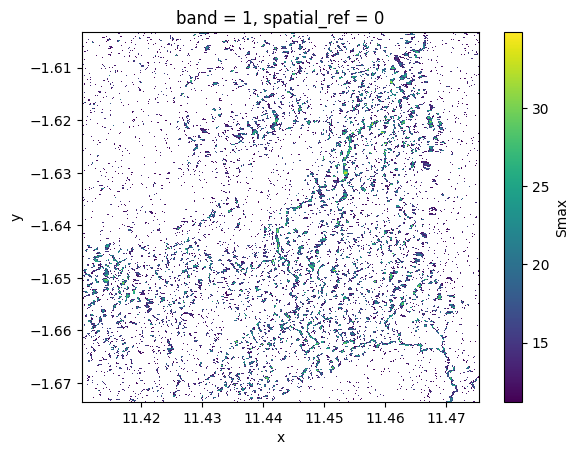

In [ ]:
max_values.plot()

PLOT GRAPH

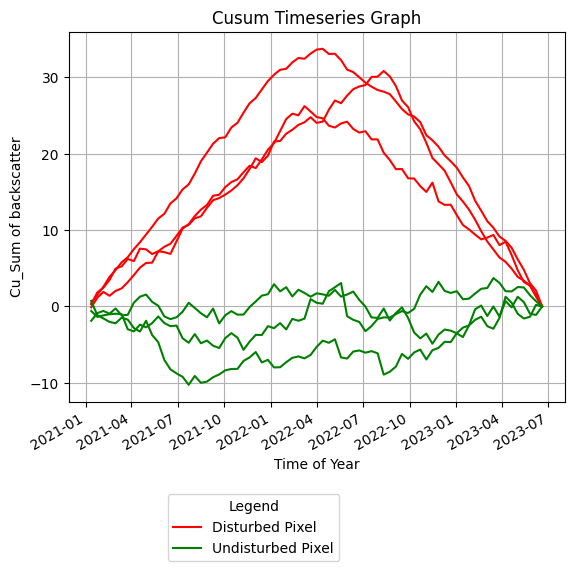

In [ ]:
import matplotlib.pyplot as plt

# Select disturbed pixel
data1 = S.sel(y=(-1.6504364), method='nearest').sel(x=11.4143162, method='nearest')
data2 =  S.sel(y=(-1.629943), method='nearest').sel(x=11.453562, method='nearest')
data3 = S.sel(y=(-1.657005), method='nearest').sel(x=11.419518, method='nearest')

# select undisturbed pixel
data4 = S.sel(y=(-1.665567), method='nearest').sel(x=11.420674, method='nearest')
data5 = S.sel(y=(-1.61540), method='nearest').sel(x=11.43580, method='nearest')
data6 = S.sel(y=(-1.63580), method='nearest').sel(x=11.43877, method='nearest')

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the graph for Disturbed Pixel
data1.plot(ax=ax, label='Disturbed Pixel', color = 'red')
data2.plot(ax=ax,color = 'red')
data3.plot(ax=ax,color = 'red')

# # Plot the graph for Undisturbed Pixel
data4.plot(ax=ax, label='Undisturbed Pixel', color = 'green')
data5.plot(ax=ax,color = 'green')
data6.plot(ax=ax,color = 'green')

# Add labels and title
plt.xlabel('Time of Year')
plt.ylabel('Cu_Sum of backscatter')
plt.title('Cusum Timeseries Graph')

plt.grid(True)

# Add a legend
plt.legend(title= 'Legend',loc='upper left',  bbox_to_anchor=(0.2, -0.25), borderaxespad=0)

# Display the plot
plt.show()

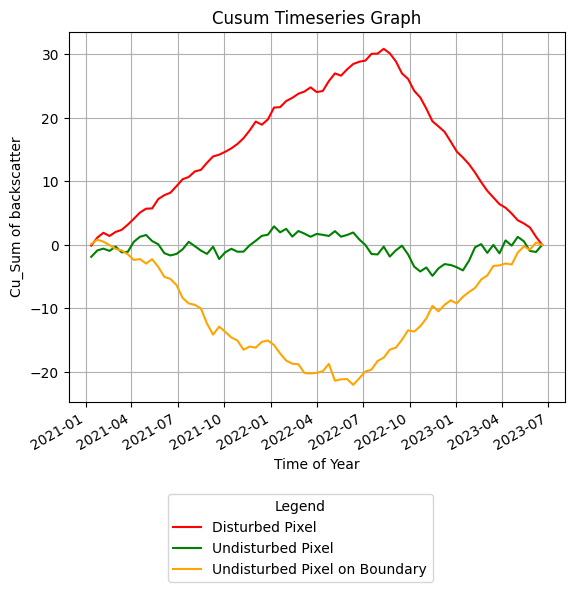

In [ ]:
# Select disturbed pixel
data1 = S.sel(y=(-1.6504364), method='nearest').sel(x=11.4143162, method='nearest')

# select undisturbed pixel
data2 = S.sel(y=(-1.665567), method='nearest').sel(x=11.420674, method='nearest')

# select negative pixel
data3 = S.sel(y=(-1.632993), method='nearest').sel(x=11.454474, method='nearest')

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the graph for Disturbed Pixel
data1.plot(ax=ax, label='Disturbed Pixel', color = 'red')

# # Plot the graph for Undisturbed Pixel
data2.plot(ax=ax, label='Undisturbed Pixel', color = 'green')

# Plot undisturbed negative pixel
data3.plot(ax=ax, label='Undisturbed Pixel on Boundary',color = 'Orange')

# Add labels and title
plt.xlabel('Time of Year')
plt.ylabel('Cu_Sum of backscatter')
plt.title('Cusum Timeseries Graph')

plt.grid(True)

# Add a legend
plt.legend(title= 'Legend',loc='upper left',  bbox_to_anchor=(0.2, -0.25), borderaxespad=0)

# Display the plot
plt.show()